# The Reciprocal Lattice Units Axis

The main object to plot data in reciprocal lattice units is the <code>RLUAxis</code> which takes care of conversion between the calculated ($Q_x$,$Q_y$) and the scattering plane in ($H$,$K$,$L$) units with the correct grid. This can at times prove difficult when dealing with non-orthogonal unit cells and/or if the scattering plane is non-trivial. For detailed technical information about the implementation see section below or the source code.

In [1]:
%matplotlib inline
from MJOLNIR.Data import DataSet
from MJOLNIR import _tools # Usefull tools useful across MJOLNIR
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['figure.dpi'] = 200

numbers = '137' # String of data numbers
fileList = _tools.fileListGenerator(numbers,folder=r'C:\Users\lass_j\Documents\CAMEA2018',year=2018) # Create file list from 2018 in specified folder

ds = DataSet.DataSet(fileList)
ds.convertDataFile(binning=8)

The RLU axis can be created directly from the <code>DataSet</code> object using the <code>Sample</code> as loaded from the data file and found in each <code>DataFile</code>. 

In [2]:
# Create RLU axis
ax = ds.createQAxis()
# Get the figure corresponding to the returned axis
fig = ax.get_figure();

# The axis should contain v1 and v2
v1 = [-1.5,-1.5,0]
v2 = [1.5,1.5,0]

ax.set_axis(v1,v2)


A couple of points are created to highlight the methods of the <code>RLUAxis</code> object. 

In [3]:
# Generate some points to plot
points = np.array([[-1,-1],[-1,1],[1,1],[1,-1],[-1,-1]]).T

# Use points as distance along projections
projection = np.array(ax.sample.inv_tr(points[0],points[1]))
# Convert into HKL (corresponds to the points above)
HKL = np.array([points[0],points[1],np.zeros_like(points[0])])

# Calculate actual position of HKL points
P1P2 = np.array(ax.sample.calculateHKLtoProjection(HKL[0],HKL[1],HKL[2]))
QxQy = np.array(ax.sample.inv_tr(P1P2[0],P1P2[1]))

The above points are converted in 3 different ways to specific locations within the plot:

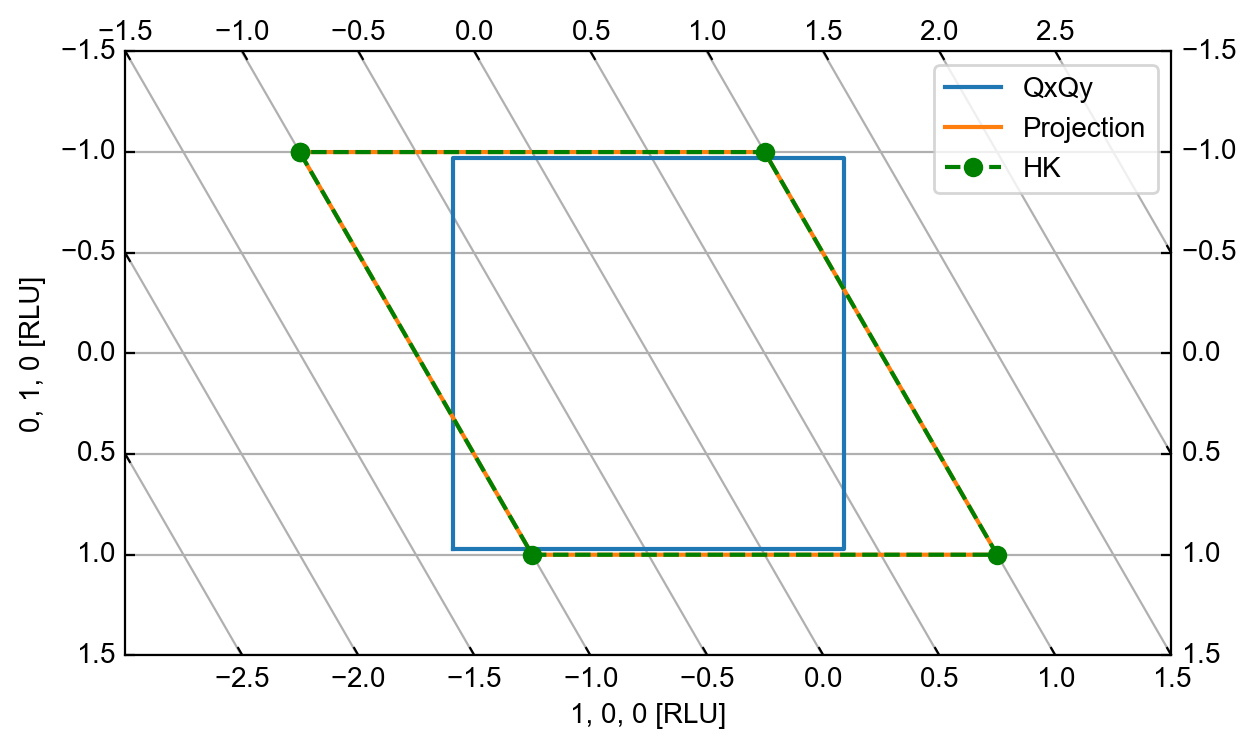

In [4]:
# Plot all 3 lines
ax.plot(points[0],points[1],label='QxQy')
ax.plot(projection[0],projection[1],label='Projection')
ax.plot(QxQy[0],QxQy[1],'g',label='HK',marker='o', linestyle='dashed')

ax.legend()

ax.grid(True)
ax.get_figure()

The first example in the code above takes a data set measured on a crystal with unit cell \[a = 6.11, b = 6.11, c = 11.35, $\alpha$ = 90, $\beta$ = 90, $\gamma$ = 120\], that is, the crystal is hexagonal and is placed in the ($H$,$K$,$0$) scattering plane. Behind the scene, data plotted in the axis is assumed to be in the ($Q_x$, $Q_y$) coordinate system rotated such that the first projection vector is along the x-axis (in this case ($H$,$0$,$0$). The data is then first converted into reciprocal space ($H$,$K$,$L$) and then into the projected in the scattering plane. This might seem like swatting flies with a sledge hammer, however, it allows for enough abstraction as to allow all cases to be plotted.

As the axis object makes use of the non-standard <code>GridHelperCurveLinear</code> many features regarding the tick marks and setting limits are not working, but see section below for a dicussion of this. A custom function has been generated to set the limits of the shown graph called <code>set_limits</code>. It takes at least two vectors in either ($H$,$K$,$L$) or projection along principal directions and assures that these are visible. Multiple vectors can be provided and it is then assured that all vector positions are visible. An example is shown in where <code>v1</code> and <code>v2</code> are assured to both be visible. In this case, providing the vectors (-1,-1.5) and (2,1,0) is sufficient as the projections are simply (1,0,0) and (0,1,0).

As to the data plotted in the axis; plotting directly into the axis corresponds to plotting the ($Q_x$, $Q_y$) system which in this case produces a square box around (0,0). However, wanting to plot things in terms of reciprocal lattice unites one has two options: Plot corresponding to projection or calculate ($Q_x$, $Q_y$) from HKL points. Both of these methods are shown in the first example resulting in the two parallellograms plotted on top of each other. Notice that the blue box does not have the same height as the two others due to the length of the ($H$,$0$,$0$) being 1.187 /AA and not unity.

In [5]:
numbers = '422' # String of data numbers
fileList = _tools.fileListGenerator(numbers,folder=r'C:\Users\lass_j\Documents\CAMEA2018',year=2018) # Create file list from 2018 in specified folder

ds = DataSet.DataSet(fileList)
ds.convertDataFile(saveFile=False)

ax = ds.createQAxis()
fig = ax.get_figure()

# The axis should contain v1 and v2

v1 = [-2,1,1]
v2 = [2,-1,-1]

ax.set_axis(v1,v2)

ax.grid(True)


The second example has a crystal with unit cell \[a = 9.843, b = 9.843, c = 9.843, $\alpha$ = 90, $\beta$ = 90, $\gamma$ = 90\], i.e. simple cubic, but the scattering plane is ($H$,$K$,$K$). Setting the limits to include all points from -2 to 2 in $H$ and from -1 to 1 in $K$ is shown in the code by providing the position vectors. The same result is obtained by simply giving (-2,-1) and (2,1) to the method.

## Techical detials

It was chosen to make use of the <code>GridHelperCurveLinear</code> despite the difficulties arising from it as this allows for plotting in RLU coordinates without having to skew data. That is, it is possible to keep data as measured by the instrument (sort of circular) while still providing all information about the reciprocal space to the user. As mentioned, some calculations happen behind the scenes when dealing with this object; most of the in the sample object itself. Mathematically what happens is as follows:

The general relationship between measured points from the instrument, denoted ($Q_x$,$Q_y$,$Q_z$) for the two in-plane components along x and y, and the one out of plane, and the reciprocal lattice units ($H$,$K$,$L$) is given by the UB matrix

$$ \begin{pmatrix}Q_x\\Q_y\\Q_z\end{pmatrix} = UB \cdot \begin{pmatrix}H\\K\\L\end{pmatrix} $$

From the geometrical constraints of the CAMEA backend, all scattering is performed in plane. Put in other words, $Q_z$ is always 0. Thus one can use a simple projection matrix from 2D to 3D:

$$ \begin{pmatrix}Q_x\\Q_y\end{pmatrix} = \underbrace{\begin{pmatrix}1 & 0 & 0\\0 & 1 & 0\end{pmatrix}}_{P_{23}} UB \cdot \begin{pmatrix}H\\K\\L\end{pmatrix} $$

As the measured space from the instrument side is 2D the points in terms of RLU are also to lay in a plane. One can make use of this by finding the two most simple projection vectors spanning this plane. Assuming they are found the projection along these are denoted $P_1$ and $P_2$. One can then project the ($H$,$K$,$L$) points long these vectors as:

$$\begin{pmatrix}H\\K\\L\end{pmatrix} = P_M \cdot \begin{pmatrix}P_0\\P_1\end{pmatrix} $$

Now remains finding the projection matrix $P_M$, which is given as the 3x2 column matrix of them divided by the square of their lengths. Putting it all together results in:

$$ \begin{pmatrix}Q_x\\Q_y\end{pmatrix} = \underbrace{\begin{pmatrix}1 & 0 & 0\\0 & 1 & 0\end{pmatrix}}_{P_{23}} UB \cdot P_M \cdot \begin{pmatrix}P_0\\P_1\end{pmatrix} $$

One further detail is that due to the way that the instrument positions, ($Q_x$,$Q_y$) are calculated, one needs to rotate this system with an angle corresponding to the “mis-alignment” of the orientation of the crystal. In reality this angle corresponds to the difference between the $A_3$ zero offset and the one for which the first projection vector is along the x-axis.

## Examples

### Example 1
Using the crystal of example 1 above, the unit cell parameters are $a = b = 6.11$, $c = 11.35$, $\alpha = \beta = 90^\circ$ and $\gamma = 120^\circ$, resulting in the reciprocal lattice vector matrix:
$$ \mathrm{RLUmatrix} = \begin{pmatrix}1.187 & 0.594 & 0.0\\ 0.0 & -1.028 & 0.0 \\ 0.0 & 0.0 & -0.554\end{pmatrix}$$

For this specific experiment, the scattering plane was ($H$,$K$,$0$) and there is a rotational offset in the sample rotation $A_3$, the resulting $UB$ matrix becomes

$$UB = \begin{pmatrix}1.097 & 0.155 & 0.0 \\ -0.454 & -1.177 & 0.0\\ 0.0 & 0.0 & -0.554 \end{pmatrix}$$

The two projection vectors being (1,0,0) and (0,1,0) the convertion matrix taking the projection along the two vectors to ($Q_x$, $Q_y$) is
$$convert = \begin{pmatrix}1.187 & 0.594 \\ 0.0 & -1.028\end{pmatrix}$$.

As seen, the transformation is non-orthogonal and thus results in the axis shown above. For the “mis-alignment” the rotation angle to correct is found to be -22.5$^\circ$. That is, all of the data is rotated by -22.5$^\circ$ before being plotted in the RLU axis.

### Example 2
For the second example shown above, with the cartesian unit cell but the non-trivial scattering plane, the matrices are:
$$UB = \begin{pmatrix}-0.418 &  0.341 & 0.341 \\ 0.482 & 0.296 & 0.296\\ 0.0 & 0.451 & -0.451\end{pmatrix}$$
$$RLUmatrix = \begin{pmatrix}0.638 &  0.0 & 0.0 \\ 0.0 & 0.638 & 0.0\\ 0.0 & 0.0 & 0.638\end{pmatrix}$$
$$convert = \begin{pmatrix} 0.638 &  0.0 \\ 0.0 & 0.638 \end{pmatrix}$$

## Tick Marks

The discussion of the location of the tick marks is quite long and deserves a section of it’s own. It all revolves about the usage of the curve linear axis, which is provided as an experimental/development feature in the matplotlib package. 

Codewise, what is done is to create two subclasses of the <code>mticker.MultipleLocator</code> and the <code>mticker.MaxLocator</code> classes designed to calculate the positions of tick marks using two different methods. The <code>MaxLocator</code> expects a integer input signifying the maximal number of ticks along the given axis, which are chosen at ‘suitable’ positions and will update with zooming and panning.

The <code>MultipleLocator</code> is designed to place tick marks at multiples of a given value. That is, if the base is 0.1, tick marks are located at all integer multiples of 0.1 inside of the viewable area. For static or panning, this solution is suitable and sufficient, but allowing the user to zoom requires the class to be more complex. In order to find a suitable base value, the class finds the window limits and given a wanted number of tick marks it finds the average wanted distance between the marks. As to be scale invariant this number is mapped to a value between 0.1 and 1, where it is compared to a predefined list of allowed fractions (1/1,1/2,1/3,1/4,1/5) where the closest is used.

With the new tick marks found, a hook is created to overview the panning and zooming of the axis and force an update of the drawing of tick marks.